In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AutoReg

## Load projected temperature data

### add Status column

In [2]:
train = pd.read_csv('DC.csv')
train['doy'] = pd.to_datetime(train['DATE']).dt.dayofyear

In [3]:
train.head()

,location,lat,long,alt,year,bloom_date,bloom_doy,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,Status,CDD,doy
0,washingtondc,38.88535,-77.038628,0.0,1936,1936-04-07,98.0,1936-09-01,-0.261498,NaN,24.5,30.491773,19.317666,1.0,24.5,245
1,washingtondc,38.88535,-77.038628,0.0,1936,1936-04-07,98.0,1936-09-02,-1.162228,NaN,22.4,27.697930,17.862821,1.0,46.9,246
2,washingtondc,38.88535,-77.038628,0.0,1936,1936-04-07,98.0,1936-09-03,4.665462,NaN,23.3,28.614220,18.088451,1.0,70.2,247
3,washingtondc,38.88535,-77.038628,0.0,1936,1936-04-07,98.0,1936-09-04,7.307400,NaN,23.9,29.356041,18.830908,1.0,94.1,248
4,washingtondc,38.88535,-77.038628,0.0,1936,1936-04-07,98.0,1936-09-05,-1.383251,NaN,23.3,28.789929,17.415694,1.0,117.4,249


In [4]:
train.tail()

,location,lat,long,alt,year,bloom_date,bloom_doy,DATE,PRCP,SNWD,TAVG,TMAX,TMIN,Status,CDD,doy
31203,NaN,NaN,NaN,NaN,2022,NaN,NaN,2022-02-05,0.0,NaN,0.7,1.7,-3.3,NaN,61.5,36
31204,NaN,NaN,NaN,NaN,2022,NaN,NaN,2022-02-06,0.0,NaN,-1.5,3.9,-5.0,NaN,60.0,37
31205,NaN,NaN,NaN,NaN,2022,NaN,NaN,2022-02-07,1.8,NaN,2.5,6.7,0.0,NaN,62.5,38
31206,NaN,NaN,NaN,NaN,2022,NaN,NaN,2022-02-08,0.0,NaN,4.5,10.0,-0.6,NaN,67.0,39
31207,NaN,NaN,NaN,NaN,2022,NaN,NaN,2022-02-09,0.0,NaN,4.4,12.2,-1.1,NaN,71.4,40


In [5]:
train.describe()

,lat,long,alt,year,bloom_doy,PRCP,SNWD,TAVG,TMAX,TMIN,Status,CDD,doy
count,3.116800e+04,3.116800e+04,31168.0,31208.000000,31168.000000,31208.000000,0.0,31208.000000,31208.000000,31208.000000,31168.000000,31208.000000,31208.000000
mean,3.888535e+01,-7.703863e+01,0.0,1978.887689,93.347215,2.814608,NaN,14.424693,19.345355,9.665757,0.748203,2407.666633,183.393745
std,1.179592e-07,6.487758e-07,0.0,24.667193,7.003289,7.640025,NaN,9.438783,10.047955,9.252062,0.434052,1927.165818,105.627480
min,3.888535e+01,-7.703863e+01,0.0,1936.000000,74.000000,-5.282122,NaN,-17.800000,-13.300000,-20.600000,0.000000,-145.600000,1.000000
25%,3.888535e+01,-7.703863e+01,0.0,1958.000000,88.000000,0.000000,NaN,6.599183,11.100000,2.200000,0.000000,442.010775,92.000000
50%,3.888535e+01,-7.703863e+01,0.0,1979.000000,94.000000,0.000000,NaN,14.882100,20.150864,9.400000,1.000000,2154.083500,184.000000
75%,3.888535e+01,-7.703863e+01,0.0,2000.000000,98.000000,2.000000,NaN,22.859640,28.300000,18.300000,1.000000,4371.037750,275.000000
max,3.888535e+01,-7.703863e+01,0.0,2022.000000,108.000000,155.200000,NaN,34.049470,40.600000,28.900000,1.000000,5971.624000,366.000000


## add prediction data

In [6]:
prediction_ds = pd.read_csv('DC_temp_forecast_10_years.csv')
prediction_ds['doy'] = pd.to_datetime(prediction_ds['date']).dt.dayofyear
prediction_ds['year'] = pd.to_datetime(prediction_ds['date']).dt.year
prediction_ds['CDD'] = (prediction_ds.groupby(['year']))['temp'].cumsum()
prediction_ds[360:370]

,Unnamed: 0,temp,date,doy,year,CDD
360,361.0,7.6,12/27/22,361,2022,5604.8
361,362.0,10.6,12/28/22,362,2022,5615.4
362,363.0,10.0,12/29/22,363,2022,5625.4
363,364.0,11.4,12/30/22,364,2022,5636.8
364,365.0,13.8,12/31/22,365,2022,5650.6
365,366.0,15.3,1/1/23,1,2023,15.3
366,367.0,3.2,1/2/23,2,2023,18.5
367,368.0,-1.3,1/3/23,3,2023,17.2
368,369.0,1.2,1/4/23,4,2023,18.4
369,370.0,4.7,1/5/23,5,2023,23.1


## Training using temperature 1940 - 2021

In [7]:
# return the upper and lower bound near p_doy, from year start to year end
def p_doy_bound(start, end):
    
    # return upper, lower, beta0, beta1, beta2
    upper = np.zeros(end - start + 1)
    lower = np.zeros(end - start + 1)
    beta0 = np.zeros(end - start + 1)
    beta1 = np.zeros(end - start + 1)
    beta2 = np.zeros(end - start + 1)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # create data column
        train_year = train[train['year'] == year][:180]
        features = ['doy', 'CDD']
        X = train_year[features]
        y = train_year.Status
        
        # fitting
        pred_model = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
        pred_model.fit(X, y)
        beta = pred_model.coef_
        
        # get probability vs. doy function
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, beta.T) - pred_model.intercept_)))
        
        # get upper and lower bound
        day_bloom = int(np.array(train_year['bloom_doy'])[0])
        
        for i in range(180):
            if p_days[i + 1, 0] > 0.5:
                lower[year - start] = p_days[i, 0]
                upper[year - start] = p_days[i + 1, 0]
                break
                
        beta0[year - start] = pred_model.intercept_[0]
        beta1[year - start] = beta[0, 0]
        beta2[year - start] = beta[0, 1]
        
    return upper, lower, beta0, beta1, beta2

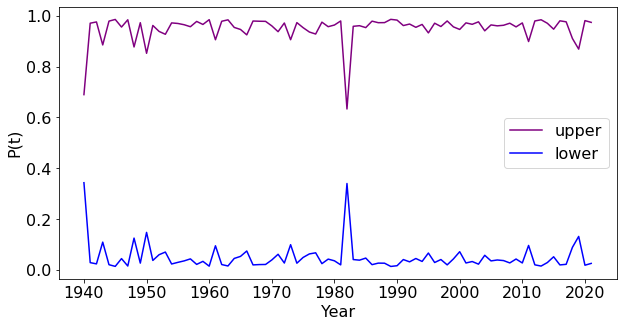

In [8]:
# plot the upper, lower bound vs. year
start = 1940
end = 2021
result = p_doy_bound(start, end)
x = np.arange(start, end + 1)

plt.figure(figsize=(10, 5))
plt.plot(x, result[0], color = 'purple', label = 'upper')
plt.plot(x, result[1], color = 'blue', label = 'lower')
plt.xlabel("Year", fontsize = 16)
plt.ylabel("P(t)", fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 16)
plt.show()

In [9]:
print(result[2])
print(result[3])
print(result[4])

[-176.82744787 -152.95793016 -167.04313605 -326.51569084 -175.52126718
 -106.76351411 -234.71521583 -169.4254379  -198.79201096 -259.92757024
 -465.71192393 -261.31640609 -353.64453504 -333.92239345 -231.05418157
 -199.98655687 -230.93356069 -262.02752348 -163.02338885 -222.47279548
 -161.09562497 -233.60293469 -153.58760558 -113.63787838 -272.85464508
 -228.77625924 -239.83357604 -197.43552975 -121.38247144 -173.53608265
 -192.47507819 -217.16998023 -231.93332415 -431.75072467 -278.25212287
 -308.91322631 -287.4463173  -168.92908464 -169.39543163 -188.19669916
 -239.89359091 -207.06346815 -267.23371307 -293.30355958 -198.60158523
 -228.91742371 -167.07238986 -159.21349872 -144.49851427 -151.1508533
 -208.6450107  -291.56565046 -252.91688135 -244.94548695 -146.73587405
 -288.09404693 -154.60313102 -259.34866855 -214.30064519 -287.26420128
 -288.00558743 -213.35624504 -305.8333546  -121.85833012 -221.34027378
 -253.1834163  -276.76911814 -207.27659952 -241.09567642 -185.37155536
 -190.2

## $\beta_i$ prediction

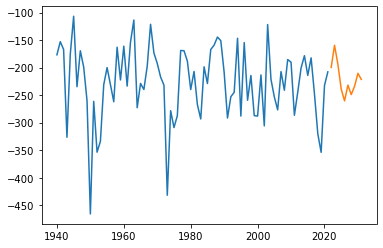

In [10]:
beta0_model = AutoReg(result[2], lags = 9, trend='c').fit()
plt.plot(range(1940, 2021+1), result[2])
plt.plot(range(2022, 2031+1), beta0_model.predict(2022-1940, 2031-1940, dynamic=False))
plt.show()

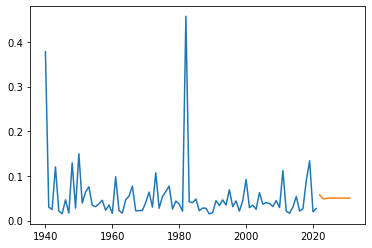

In [11]:
beta1_model = AutoReg(result[3], lags = 3, trend='c').fit()
plt.plot(range(1940, 2021+1), result[3])
plt.plot(range(2022, 2031+1), beta1_model.predict(2022-1940, 2031-1940, dynamic=False))
plt.show()

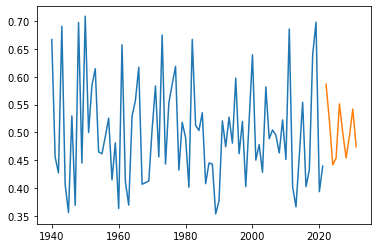

In [12]:
beta2_model = AutoReg(result[4], lags = 13, trend='c').fit()
plt.plot(range(1940, 2021+1), result[4])
plt.plot(range(2022, 2031+1), beta2_model.predict(2022-1940, 2031-1940, dynamic=False))
plt.show()

## predict doy for 2022 - 2031

In [13]:
beta0_model = AutoReg(result[2], lags = 9, trend='c').fit()
beta1_model = AutoReg(result[3], lags = 3, trend='c').fit()
beta2_model = AutoReg(result[4], lags = 13, trend='c').fit()
# predict the blooming doy
# return the predicted doy
def predict_blooming_beta_ts(start, end):
    
    training_start = 1940
    
    predict = np.zeros(end - start + 1)
    
    beta0_pre = beta0_model.predict(start-training_start, end-training_start, dynamic=False)
    beta1_pre = beta1_model.predict(start-training_start, end-training_start, dynamic=False)
    beta2_pre = beta2_model.predict(start-training_start, end-training_start, dynamic=False)
    
    for year in range(start, end + 1):
        year_str = str(year)
        
        # build the predict doy array
        if year >= start + 1:
            CU = np.average(prediction_ds[prediction_ds['year'] == year - 1][-71:]['temp'])
        else:
            CU = np.average(train[train['year'] == year - 1][-71:]['TAVG'])
        
        pre_year = prediction_ds[prediction_ds['year'] == year][:180]
        features = ['doy', 'CDD']
        X = pre_year[features]
        
        # time series predict beta_i
        b = np.array([[beta1_pre[year - start], beta2_pre[year - start]]])
        # b0 = np.array([beta0_pre[year - start]])
        if CU < 6.5:
            b0 = np.array([beta0_pre[year - start] + 50])
        elif CU > 8:
            b0 = np.array([beta0_pre[year - start] - 40])
        else:
            b0 = np.array([beta0_pre[year - start]])
        
        p_days = np.array(1 / (1 + np.exp(- np.matmul(X, b.T) - b0)))
        
        for i in range(180):
            if p_days[i, 0] > 0.5:
                predict[year - start] = i + 1
                break
        
    return predict


[ 90.  88.  80.  99. 100. 100.  85.  84.  95.  91.  80.  87.]


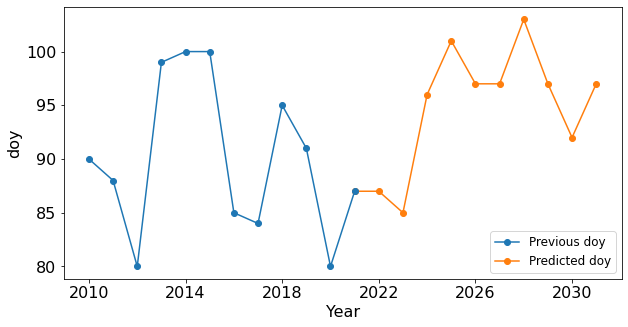

In [16]:
# plot the predict, real doy vs. year
start = 2022
end = 2031
result_pred_ts = predict_blooming_beta_ts(start, end)
x_r = np.arange(2010, 2021 + 1)
x_p = np.arange(start, end + 1)

show_start = 2010
show_end = 2021
day_bloom_array = np.zeros(show_end - show_start + 1)
for y in range(show_start, show_end + 1):
    train_y = train[train['year'] == y]
    day_bloom_array[y - show_start] = int(np.array(train_y['bloom_doy'])[0])
print(day_bloom_array)

f = plt.figure(figsize=(10, 5))
plt.plot(x_r, day_bloom_array, 'o-', label = 'Previous doy')
# plt.plot(x_p, result_pred_ts, 'o-', label = 'Predicted doy')
plt.plot(np.arange(start - 1, end + 1), np.insert(result_pred_ts, 
                                    0, day_bloom_array[-1]), 'o-', label = 'Predicted doy', zorder = 1)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("doy", fontsize = 16)
plt.xticks(np.arange(2010, 2033, 4), fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend(fontsize = 12, loc = 'lower right')
plt.show()
# f.savefig("../result_figures/washington_prediction.png", bbox_inches='tight', dpi=1200)

In [15]:
print(result_pred_ts)

[ 87.  85.  96. 101.  97.  97. 103.  97.  92.  97.]
